### Loading in the cleaned data and setting up my environment

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use("fast")

In [3]:
orders = pd.read_csv("orders_cleaned.csv")
campaigns= pd.read_csv("campaign_cleaned.csv")
order_process = pd.read_csv("order_process_cleaned.csv")
intern_study = pd.read_csv("intern_study_cleaned.csv")

In [4]:
orders.head()

,order_id,order_date,ship_mode,product_id
0,CA-2019-121755,2019-01-16,Second Class,TEC-AC-10003027
1,CA-2019-118255,2019-03-11,First Class,TEC-AC-10000171
2,CA-2019-169194,2019-06-20,Standard Class,TEC-AC-10002167
3,CA-2019-111682,2019-06-17,First Class,TEC-AC-10002167
4,CA-2018-135545,2018-11-24,Standard Class,TEC-AC-10004633


In [5]:
campaigns.head()

,order_id,arrival_scan_date
0,CA-2019-109666,2019-05-03
1,CA-2019-138933,2019-05-03
2,CA-2019-130001,2019-05-03
3,CA-2019-113061,2019-05-06
4,CA-2019-162138,2019-05-06


In [6]:
intern_study.head()

,order_id,ready_to_ship_date,pickup_date
0,CA-2019-116540,2019-09-02,2019-09-03
1,CA-2019-116540,2019-09-02,2019-09-03
2,CA-2019-129847,2019-09-04,2019-09-04
3,CA-2019-129630,2019-09-04,2019-09-04
4,CA-2019-106278,2019-09-05,2019-09-06


In [7]:
order_process

,order_id,order_date,on_truck_scan_date,ship_mode
0,CA-2019-125206,2019-01-03,2019-01-07,Express
1,CA-2019-160304,2019-01-02,2019-01-09,Standard Processing
2,CA-2019-160304,2019-01-02,2019-01-09,Standard Processing
3,US-2019-116365,2019-01-03,2019-01-09,Standard Processing
4,US-2019-116365,2019-01-03,2019-01-09,Standard Processing
...,...,...,...,...
5894,CA-2020-143259,2020-12-30,2021-01-06,Standard Processing
5895,CA-2020-143259,2020-12-30,2021-01-06,Standard Processing
5896,CA-2020-115427,2020-12-30,2021-01-06,Standard Processing
5897,CA-2020-115427,2020-12-30,2021-01-06,Standard Processing


![Flowchart and KPIs](Flowchart%20Museli.png)


## KPI 1: Order Prep Time

**What is the `average time taken` for an order to be prepared for shipping?** 

This includes the processing that takes place between the following phases: 
- order is received by the system
- items in the order will be picked and packed
- order will be marked as "ready to ship"

Calculated difference in number of days between the order date  and the ready to ship date
`ready_to_ship - order_date`.  
Use the `mean` to find `average time taken` .

**Steps to take:**
1. Merge orders and intern_study
2. Inspect and drop any duplicate rows
3. Convert dates to datetime
4. Extract day of week
5. Calculate the difference in number of days between the order date and the arrival_scan_date
`arrival_scan_date - order_date`
6. Use the `mean` to find `average time taken`** .


In [8]:
#1. merge intern_study and orders on order_id
orders_intern = orders.merge(intern_study,on="order_id", how="inner") 

# check for the shape, 753 rows
orders_intern.shape

duplicates = orders_intern[orders_intern.duplicated(keep=False)]

#2. dropping duplicate rows
orders_intern_dedup = orders_intern.drop_duplicates().copy()

#checking for duplicates in order_id
orders_intern_dedup.duplicated(subset=["order_id"]).value_counts()

orders_intern_dedup[orders_intern_dedup.duplicated(subset="order_id",keep=False)].sort_values("order_id")
print(len(orders_intern_dedup))

#2b. Dropping duplicate order_ids
orders_intern_dedup = orders_intern_dedup.drop_duplicates(subset="order_id")
print(len(orders_intern_dedup))

#3. casting order_date and ready_to_ship_date to datetime format
orders_intern_dedup["order_date"] = pd.to_datetime(orders_intern_dedup["order_date"])
orders_intern_dedup["ready_to_ship_date"] = pd.to_datetime(orders_intern_dedup["ready_to_ship_date"])
orders_intern_dedup["pickup_date"] = pd.to_datetime(orders_intern_dedup["pickup_date"])

#4. extracting day of week
orders_intern_dedup["order_date_dow"] = orders_intern_dedup["order_date"].dt.day_name()

#5. Calculating difference 
orders_intern_dedup["order_to_ready"] = orders_intern_dedup["ready_to_ship_date"] - orders_intern_dedup["order_date"]
orders_intern_dedup["order_to_ready_int"] = orders_intern_dedup["order_to_ready"].dt.days

417
204


There are duplicates in the order_id. This makes sense because if many products are ordered in the same session, there will be one order_id generated for the whole order, but many rows for each product ordered. My assumption is that the ready to ship date and order date will match for each row with a duplicated order_id. Let´s check that first.

The check of duplicated order id´s show that all individual products with the same order id have the same dates associated.  
Therefore, these rows can be safely dropped, keeping only unique order id´s. 

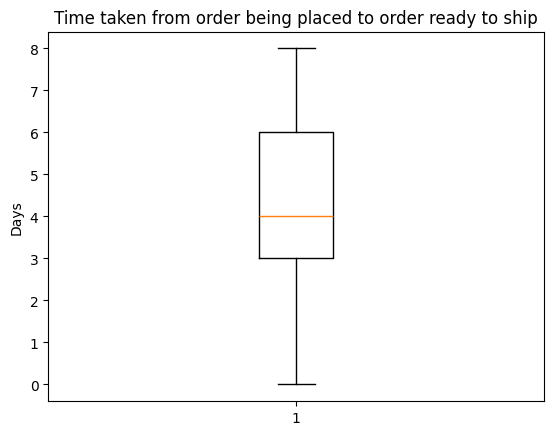

In [9]:
#Plotting the distribution of time taken from order placed to order ready in warehouse
plt.boxplot(x=orders_intern_dedup["order_to_ready_int"])
plt.title("Time taken from order being placed to order ready to ship")
plt.ylabel("Days")
plt.show();

In [10]:
#6. Calculating mean
orders_intern_dedup["order_to_ready_int"].describe().reset_index()

,index,order_to_ready_int
0,count,204.000000
1,mean,4.176471
2,std,1.969780
3,min,0.000000
4,25%,3.000000
5,50%,4.000000
6,75%,6.000000
7,max,8.000000


**KPI1 : ORDER PREP TIME**

In [11]:
orders_intern_dedup["order_to_ready_int"].mean().round(2)

np.float64(4.18)

The average time taken for an order to be made ready for shipping from when the order is placed is `4.18 days`.

According to the Warehouse Manager, this process should take `2 days`.

---

## KPI 2: Pick up time

**How long `on average` does the order take to leave the warehouse from when it is made ready to ship?**

Note:  
    For Express orders, we should expect no more than 1 day (according to warehouse manager)  
    For Standard orders, we should expect no more than 2 days (according to warehouse manager)

Calculated difference in number of days between On Truck Scan Date and Ready to Ship date
 - `pickup_date`- `ready_to_ship`
 - grouped by standard or express processing
 - use the `mean`to find `average time taken`

Steps to take:
1. check for duplicates
2. convert dates to datetime format
3. calculate average pick up time

----


In [15]:
#1. Check for duplicates
duplicates = intern_study[intern_study.duplicated()]

print(len(duplicates))

#no order_id duplicates
print(len(intern_study[intern_study.duplicated(subset="order_id",keep=False)]))

#2. Converting dates to datetime format
intern_study["ready_to_ship_date"] = pd.to_datetime(intern_study["ready_to_ship_date"])
intern_study["pickup_date"] = pd.to_datetime(intern_study["pickup_date"])

intern_study["ready_to_pickup"] = intern_study["pickup_date"] - intern_study["ready_to_ship_date"]
intern_study["ready_to_pickup_int"] = intern_study["ready_to_pickup"].dt.days

#3. Calculate average pick up time
intern_study["ready_to_pickup_int"].mean().round(2)


0
0


np.float64(1.57)

**KPI2 : ORDER PICK UP TIME**

In [16]:
intern_study["ready_to_pickup_int"].mean().round(2)

np.float64(1.57)

In [17]:
#plotting the distribution

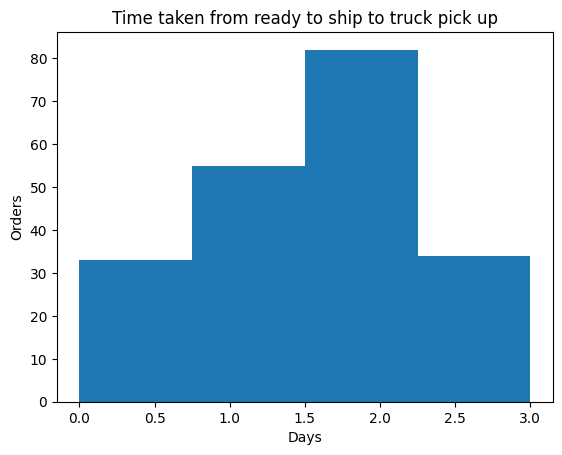

In [18]:
plt.hist(x=intern_study["ready_to_pickup_int"],bins=4)
plt.title("Time taken from ready to ship to truck pick up")
plt.xlabel("Days")
plt.ylabel("Orders")
plt.show();

In [21]:
intern_study["ready_to_pickup_int"].describe().reset_index(name="dispatch time")

,index,dispatch time
0,count,204.000000
1,mean,1.573529
2,std,0.951786
3,min,0.000000
4,25%,1.000000
5,50%,2.000000
6,75%,2.000000
7,max,3.000000


The average time taken for order pick up from the warehouse is `1.57 days`. But we need to investigate further.
How is this affected by
- Express vs. Standard shipping
- Weekend vs. Weekday?

In [59]:
orderprocess_intern =  intern_study.merge(order_process, on="order_id")

In [60]:
orderprocess_intern

,order_id,ready_to_ship_date,pickup_date,ready_to_pickup,ready_to_pickup_int,order_date,on_truck_scan_date,ship_mode
0,CA-2019-116540,2019-09-02,2019-09-03,1 days,1,2019-09-02,2019-09-03,Express
1,CA-2019-116540,2019-09-02,2019-09-03,1 days,1,2019-09-02,2019-09-03,Express
2,CA-2019-129847,2019-09-04,2019-09-04,0 days,0,2019-09-02,2019-09-04,Express
3,CA-2019-129630,2019-09-04,2019-09-04,0 days,0,2019-09-04,2019-09-04,Express
4,CA-2019-129630,2019-09-04,2019-09-04,0 days,0,2019-09-04,2019-09-04,Express
...,...,...,...,...,...,...,...,...
413,CA-2020-105333,2020-12-04,2020-12-07,3 days,3,2020-11-30,2020-12-07,Standard Processing
414,CA-2020-105333,2020-12-04,2020-12-07,3 days,3,2020-11-30,2020-12-07,Standard Processing
415,CA-2020-119305,2020-12-04,2020-12-07,3 days,3,2020-11-30,2020-12-07,Standard Processing
416,CA-2020-142090,2020-12-07,2020-12-09,2 days,2,2020-11-30,2020-12-09,Standard Processing




-----------------------

## KPI 4: Total order cycle time

**What is the `average time taken` for a customer to receive an order after they have placed it?** 


**Steps to be taken:**

campaign table has `arrival_scan_date` and order table has `order_date`.

1. Merge orders and campaign
2. Inspect and drop duplicates
3. Convert dates to datetime if needed
4. Calculate the difference in number of days between the order date and the arrival_scan_date
`arrival_scan_date - order_date`
5. Use the `mean` to find `average time taken`** .

In [29]:
#1. merge orders and campaign
order_cycle = orders.merge(campaigns, on="order_id", how="inner")

#Inspect duplicates
len(order_cycle[order_cycle.duplicated(keep=False)])

#order_id duplicates?
print(len(order_cycle[order_cycle.duplicated(subset="order_id",keep=False)]))

#drop them
order_cycle = order_cycle.drop_duplicates(subset="order_id").copy()
print(len(order_cycle))

#3. Convert to datetime
order_cycle["order_date"] = pd.to_datetime(order_cycle["order_date"])
order_cycle["arrival_scan_date"] = pd.to_datetime(order_cycle["arrival_scan_date"])

#4. Calculate the difference between arrival_scan_date and order_date
order_cycle["order_cycle_time"] = order_cycle["arrival_scan_date"] - order_cycle["order_date"]
order_cycle["order_cycle_time_int"] = order_cycle["order_cycle_time"].dt.days

#5. Calculate the mean
order_cycle["order_cycle_time_int"].mean()

497
333


np.float64(10.834834834834835)

In [30]:
order_cycle["order_cycle_time_int"].describe().reset_index(name="lead time")

,index,lead time
0,count,333.000000
1,mean,10.834835
2,std,2.862257
3,min,3.000000
4,25%,9.000000
5,50%,11.000000
6,75%,13.000000
7,max,17.000000


**KPI4 : TOTAL CYCLE TIME**


In [32]:
order_cycle["order_cycle_time_int"].mean().round(2)

np.float64(10.83)

The average time taken for an order to delivered to the customer from when the order is placed is `10.83 days`.


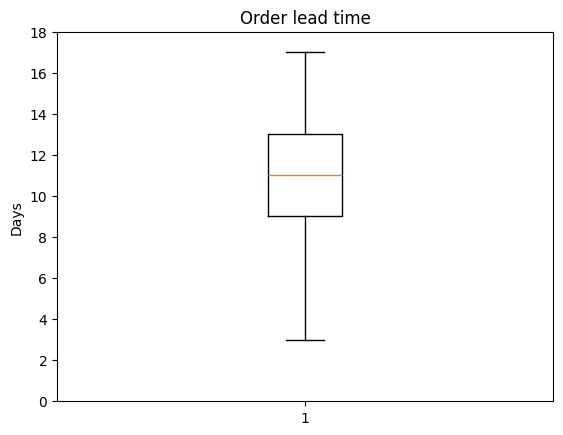

In [34]:
#Plotting the distribution of time taken from order placed to order ready in warehouse
plt.boxplot(x=order_cycle["order_cycle_time_int"])
plt.ylim([0,18])
plt.title("Order lead time")
plt.ylabel("Days")
plt.show();